# jupiter ноутбук с экспериментами - черновик


In [33]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import demoji
import difflib
from razdel import sentenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import pickle



[nltk_data] Downloading package punkt to /Users/ilmira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilmira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ilmira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
def get_unnecessary_text(row):
    """
    Берет строку датафрейма, сравнивает ДО/У/ТС/Пр 
    и возвращет неиспользуемый текст
    """
    if len(row['responsibilities']) < 1:
        return ""
    
    # пока задаем так
    unnecessary_text = row['responsibilities']

    # вытаскиваем из unnecessary_text - текст (requirements)
    if len(row['requirements']) > 8:
        diff = difflib.ndiff(unnecessary_text.split(), row['requirements'].split())
        unnecessary_text = ' '.join([word[2:] for word in diff if word.startswith('- ')])

    # вытаскиваем из unnecessary_text - текст (terms)
    if len(row['terms']) > 8:
        diff = difflib.ndiff(unnecessary_text.split(), row['terms'].split())
        unnecessary_text = ' '.join([word[2:] for word in diff if word.startswith('- ')])

    # вытаскиваем из unnecessary_text - текст (notes)
    if len(row['notes']) > 8:
        diff = difflib.ndiff(unnecessary_text.split(), row['notes'].split())
        unnecessary_text = ' '.join([word[2:] for word in diff if word.startswith('- ')])

    return unnecessary_text


def del_emoji(text):
    text = demoji.replace(str(text), "")
    text = text.replace("✔", "").replace("▉", "")
    return text


def split_sentences(text):
    return [sentence.text for sentence in sentenize(text)]


def get_df_with_labels(input_series, label):
    combined_list = sum(input_series.tolist(), [])
    res_df = pd.DataFrame(
        {'text': combined_list, 'label': label}
    )
    res_df = res_df[
        (res_df['text'] != "") &
        (res_df['text'] != " ") &
        (res_df['text'] != "-") &
        (res_df['text'] != "\\N")
    ]
    
    return res_df


def get_df_for_training():

    df_1 = get_df_with_labels(
        df['unnecessary_text_split'],
        label='null_class'
    )

    df_2 = get_df_with_labels(
        df['requirements_split'],
        label='requirements'
    )

    df_3 = get_df_with_labels(
        df['terms_split'],
        label='terms'
    )

    df_4 = get_df_with_labels(
        df['notes_split'],
        label='notes'
    )

    res_df = pd.concat([df_1, df_2, df_3, df_4]).reset_index(drop=True)
    return res_df


def preprocess_text(text):

    # к нижнему регистру
    text = text.lower()
    
    # чистим с помощью регулярок
    text = del_n.sub(' ', text)
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)

    # токенизация
    tokens = word_tokenize(text)

    # удаление стоп-слов
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]

    # лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # объединение токенов обратно в предложение
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [35]:

# Загрузка данных из файла Excel
df = pd.read_excel('../data/data_train.xlsx', sheet_name='МАКСУ')


# отбор колонок
cols = [
    # 'id',
    'responsibilities(Должностные обязанности)',
    'requirements(Требования к соискателю)',
    'terms(Условия)',
    'notes(Примечания)'
]
df = df[cols].set_index(pd.Index(range(2, len(df) + 2)))

# переименование для удоства
df = df.rename(
    columns={
        'responsibilities(Должностные обязанности)': 'responsibilities',
        'requirements(Требования к соискателю)': 'requirements',
        'terms(Условия)': 'terms',
        'notes(Примечания)': 'notes'
    }
)

# заполнение NaN
df['responsibilities'] = df['responsibilities'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['terms'] = df['terms'].fillna('')
df['notes'] = df['notes'].fillna('')

# удаление смайлов и посторонних символов - препроцессинг по всем нужным колонкам
# df = df.applymap(preprocess_text)

df = df.applymap(del_emoji)



/Users/ilmira/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [36]:
df.columns

Index(['responsibilities', 'requirements', 'terms', 'notes'], dtype='object')

In [37]:
stop_words = set(stopwords.words('russian'))  # Замените 'english' на язык вашего текста
lemmatizer = WordNetLemmatizer()


# --- Для обучения ---

In [38]:
# вытащим текст для обучения

# текст, который не используется в колонках (null_class)
df['unnecessary_text'] = df.apply(
    get_unnecessary_text,
    axis=1
)


In [39]:
# # выделение предложений
df['unnecessary_text_split'] = df['unnecessary_text'].apply(split_sentences)
# df['responsibilities_split'] = df['responsibilities'].apply(split_sentences)
df['requirements_split'] = df['requirements'].apply(split_sentences)
df['terms_split'] = df['terms'].apply(split_sentences)
df['notes_split'] = df['notes'].apply(split_sentences)

# # # выделение предложений
# df['unnecessary_text_split'] = df['unnecessary_text'].apply(sent_tokenize)
# # df['responsibilities_split'] = df['responsibilities'].apply(split_sentences)
# df['requirements_split'] = df['requirements'].apply(sent_tokenize)
# df['terms_split'] = df['terms'].apply(sent_tokenize)
# df['notes_split'] = df['notes'].apply(sent_tokenize)


In [40]:
df_for_training = get_df_for_training()
df_for_training

,text,label
0,Гнутье арматурной стали на механических станка...,null_class
1,Сборка и установка сеток и плоских...,null_class
2,Вязка арматуры.,null_class
3,станках.,null_class
4,Выполнение работ по сборке и вязке арматурных ...,null_class
...,...,...
9430,Плюсом 7000 рублей в месяц каждому монтажнику ...,notes
9431,"Работа не сложная, берём без опыта (обучаем)",notes
9432,Наша компания является прямым работодателем с ...,notes
9433,Более 17 лет работаем на рынке труда и предост...,notes


In [41]:
df_for_training['label'].value_counts()

null_class      3913
terms           3377
requirements    1646
notes            499
Name: label, dtype: int64

In [42]:
# # разбивка на отдельные предложения

# df['unnecessary_text'].apply(split_sentences)
# df['responsibilities'].apply(split_sentences)
# df['requirements'].apply(split_sentences)
# df['terms'].apply(split_sentences)
# df['notes'].apply(split_sentences)


# len_unnecessary_text = df['unnecessary_text'].apply(split_sentences).apply(len).sum()
# len_responsibilities = df['responsibilities'].apply(split_sentences).apply(len).sum()
# len_requirements = df['requirements'].apply(split_sentences).apply(len).sum()
# len_terms = df['terms'].apply(split_sentences).apply(len).sum()
# len_notes = df['notes'].apply(split_sentences).apply(len).sum()


# print('Кол-во предложений в НТ:', len_unnecessary_text)
# print('Кол-во предложений в ДО:', len_responsibilities)
# print('Кол-во предложений в ТС:', len_requirements)
# print('Кол-во предложений в У: ', len_terms)
# print('Кол-во предложений в Пр:', len_notes)
# print('Кол-во разметки:        ', len_requirements + len_terms + len_notes)

In [43]:
# # регулярки для чистки 
# перенос каретки
del_n = re.compile('\n')               
# html-теги
del_tags = re.compile('<[^>]*>')        
# содержимое круглых скобок
del_brackets = re.compile('\([^)]*\)')  
# clean_text = re.compile('[^а-яa-z\s]')  # все небуквенные символы кроме пробелов
# del_spaces = re.compile('\s{2,}')

In [44]:
# df['preprocessed_text'] = 
df_for_training['text'] = df_for_training['text'].apply(preprocess_text)


In [45]:
df_for_training

,text,label
0,гнутье арматурной стали механических станках к...,null_class
1,сборка установка сеток плоских ...,null_class
2,вязка арматуры,null_class
3,станках,null_class
4,выполнение работ сборке вязке арматурных сеток...,null_class
...,...,...
9430,плюсом 7000 рублей месяц каждому монтажнику св...,notes
9431,работа сложная берём опыта,notes
9432,наша компания является прямым работодателем бе...,notes
9433,17 лет работаем рынке труда предоставляем рабо...,notes


In [46]:
# TF-IDF
# tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(
    # ngram_range=(2, 4),
    # analyzer='char_wb'
    # sublinear_tf=True,
    # use_idf=False,
    # norm='l1'
    # norm=None
)

# разбили данные train / test
X_train, X_test, y_train, y_test = train_test_split(
    df_for_training['text'], 
    df_for_training['label'], 
    test_size=0.10, 
    random_state=42
)

# обучаем и применяем tfidf
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [47]:
# tfidf_vectorizer.get_feature_names_out()

In [48]:
# Обучение классификатора на TF-IDF признаках
classifier = LogisticRegression(max_iter=1000)
# classifier = SVC(class_weight='balanced')

classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [49]:
# оценка точности модели
y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("f1_score:", f1)
print(classification_report(y_test, y_pred))

Accuracy: 0.7976694915254238
f1_score: 0.6887757703159243
              precision    recall  f1-score   support

       notes       0.59      0.22      0.32        45
  null_class       0.75      0.85      0.80       386
requirements       0.90      0.71      0.79       168
       terms       0.83      0.86      0.84       345

    accuracy                           0.80       944
   macro avg       0.77      0.66      0.69       944
weighted avg       0.80      0.80      0.79       944



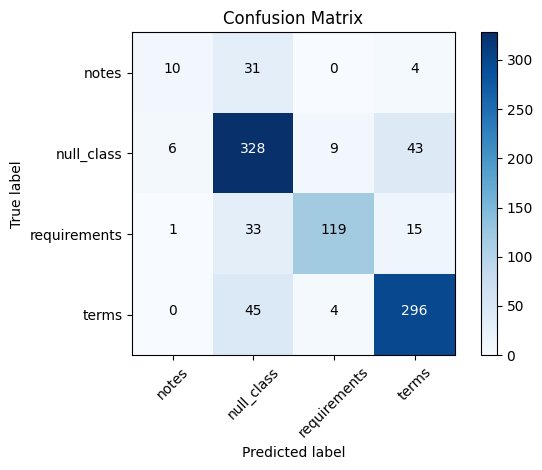

In [50]:
# Пример использования
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [51]:
cm

array([[ 10,  31,   0,   4],
       [  6, 328,   9,  43],
       [  1,  33, 119,  15],
       [  0,  45,   4, 296]])

In [ ]:
# exp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Определение модели
model = LogisticRegression(max_iter=2000)

# Определение сетки параметров для перебора
param_grid = {
    'C': [0.1, 1, 5, 7, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'class_weight': ['balanced', None]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели на данных с подбором параметров
grid_search.fit(X_train_tfidf, y_train)

# Вывод лучшего набора параметров и соответствующей метрики
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Оценка модели на тестовых данных
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


In [ ]:
# Пример использования
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [34]:
df_for_training['label'].value_counts()

null_class      3913
terms           3377
requirements    1646
notes            499
Name: label, dtype: int64

In [35]:
# # Преобразование текстовых данных в TF-IDF признаки
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Обучение классификатора на TF-IDF признаках
# classifier = LogisticRegression()
# classifier.fit(X_train_tfidf, y_train)

# # Оценка точности модели
# accuracy = classifier.score(X_test_tfidf, y_test)
# print("Accuracy:", accuracy)

In [64]:
# # Определение модели
# model = LogisticRegression()

# # Определение сетки параметров для перебора
# param_grid = {
#     'C': [0.1, 1, 10],
#     'penalty': ['l1', 'l2']
# }

# Определение модели

model = SVC()

# Определение сетки параметров для перебора
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели на данных с подбором параметров
grid_search.fit(X_train_tfidf, y_train)

# Вывод лучшего набора параметров и соответствующей метрики
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Оценка модели на тестовых данных
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.8001419112330332
              precision    recall  f1-score   support

       notes       0.65      0.29      0.40        45
  null_class       0.78      0.85      0.81       386
requirements       0.87      0.73      0.79       168
       terms       0.84      0.88      0.86       345

    accuracy                           0.81       944
   macro avg       0.78      0.69      0.72       944
weighted avg       0.81      0.81      0.81       944



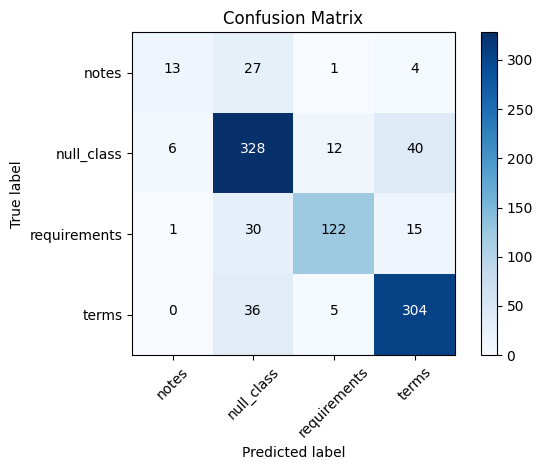

In [66]:
# Пример использования
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [51]:
# # Определение модели

# Определение модели
model = SVC()

# Определение сетки параметров для перебора
param_grid = {
    'C': [0.1, 1, 3, 6, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели на данных с подбором параметров
grid_search.fit(X_train_tfidf, y_train)

# Вывод лучшего набора параметров и соответствующей метрики
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Оценка модели на тестовых данных
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.8001419112330332
              precision    recall  f1-score   support

       notes       0.65      0.29      0.40        45
  null_class       0.78      0.85      0.81       386
requirements       0.87      0.73      0.79       168
       terms       0.84      0.88      0.86       345

    accuracy                           0.81       944
   macro avg       0.78      0.69      0.72       944
weighted avg       0.81      0.81      0.81       944



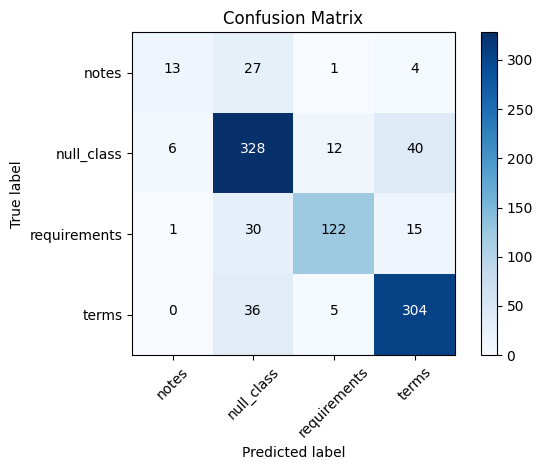

In [53]:
# Пример использования
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# # Разделение данных на обучающий и тестовый наборы
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели бустинга
model = GradientBoostingClassifier()

# Обучение модели
model.fit(X_train_tfidf, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test_tfidf)

# Оценка точности
y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("f1_score:", f1)
print(classification_report(y_test, y_pred))

Accuracy: 0.7976694915254238
f1_score: 0.6887757703159243
              precision    recall  f1-score   support

       notes       0.59      0.22      0.32        45
  null_class       0.75      0.85      0.80       386
requirements       0.90      0.71      0.79       168
       terms       0.83      0.86      0.84       345

    accuracy                           0.80       944
   macro avg       0.77      0.66      0.69       944
weighted avg       0.80      0.80      0.79       944



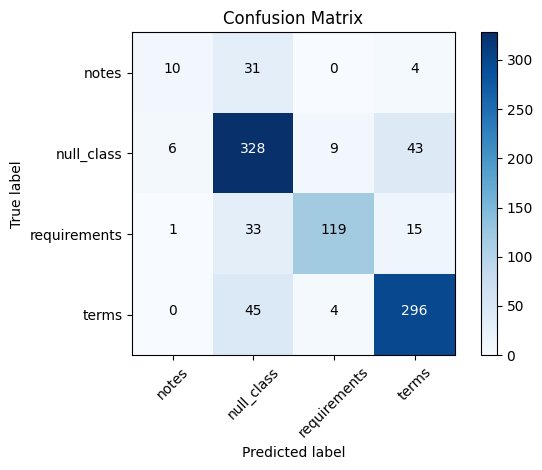

In [39]:
# Пример использования
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

# # Определение модели бустинга
# model = GradientBoostingClassifier()

# # Определение сетки параметров для перебора
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 7, 10]
# }

# # Создание экземпляра GridSearchCV
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# # Обучение модели на данных с подбором параметров
# grid_search.fit(X_train_tfidf, y_train)

# # Вывод лучшего набора параметров и соответствующей метрики
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

In [56]:
# # Пример использования
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV



# Определение модели RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Определение сетки параметров для перебора
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели на данных с подбором параметров
grid_search.fit(X_train_tfidf, y_train)

# Вывод лучшего набора параметров и соответствующей метрики
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Прогнозирование классов для тестовой выборки с лучшими параметрами
y_pred = grid_search.predict(X_test_tfidf)

# Вычисление точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}
Best score: 0.8017908407287319
Accuracy: 0.8008474576271186


In [ ]:
# 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV



# Определение модели RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Определение сетки параметров для перебора
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, 10, 15]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели на данных с подбором параметров
grid_search.fit(X_train_tfidf, y_train)

# Вывод лучшего набора параметров и соответствующей метрики
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Прогнозирование классов для тестовой выборки с лучшими параметрами
y_pred = grid_search.predict(X_test_tfidf)

# Вычисление точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


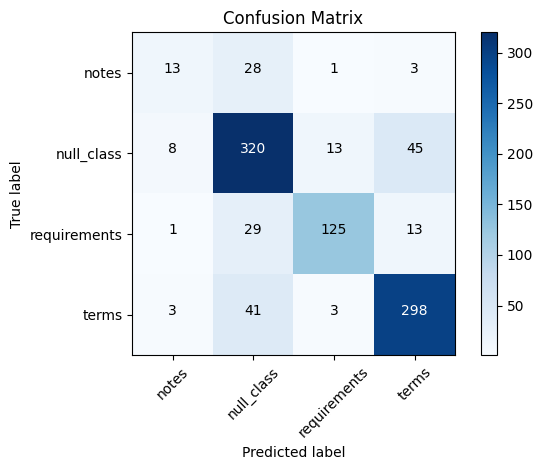

In [ ]:
# Пример использования
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV

# # Создание экземпляра классификатора
# classifier = KNeighborsClassifier()

# # Определение сетки параметров для перебора
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9]
# }

# # Создание экземпляра GridSearchCV
# grid_search = GridSearchCV(classifier, param_grid, cv=5)

# # Обучение классификатора с подбором параметров
# grid_search.fit(X_train_tfidf, y_train)

# # Вывод лучшего набора параметров и соответствующей метрики
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# # Применение обученного классификатора для предсказания меток
# y_pred = grid_search.predict(X_test_tfidf)
# # Вычисление точности модели
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # Пример использования
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()


In [ ]:
# # Пример использования
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [25]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import GridSearchCV

# # Создание экземпляра классификатора
# classifier = AdaBoostClassifier(random_state=42)

# # Определение сетки параметров для перебора
# param_grid = {
#     'n_estimators': [50, 100, 200]
#     # 'learning_rate': [0.1, 0.5, 1.0]
# }

# # Создание экземпляра GridSearchCV
# grid_search = GridSearchCV(classifier, param_grid, cv=5)

# # Обучение классификатора с подбором параметров
# grid_search.fit(X_train_tfidf, y_train)

# # Вывод лучшего набора параметров и соответствующей метрики
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# # Применение обученного классификатора для предсказания меток
# y_pred = grid_search.predict(X_test_tfidf)

# # Вычисление точности модели
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [ ]:
# # Пример использования
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [24]:
# from sklearn.naive_bayes import GaussianNB

# # Создание экземпляра классификатора
# classifier = GaussianNB()

# # Обучение классификатора
# classifier.fit(X_train_tfidf.toarray(), y_train)

# # Применение обученного классификатора для предсказания меток
# y_pred = classifier.predict(X_test_tfidf.toarray())

# # Вычисление точности модели
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # Пример использования
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [67]:
# # Сохранение модели в файл с помощью pickle
# with open('model.pkl', 'wb') as f:
#     pickle.dump(classifier, f)

# # cохранение модели TfidfVectorizer с помощью pickle
# with open('vectorizer.pkl', 'wb') as file:
#     pickle.dump(tfidf_vectorizer, file)

# Применение


In [3]:
# загрузка
df = pd.read_excel('../data/data.xlsx')


In [4]:
df.head(2)

,id,name(название),specialization(специализация),responsibilities(Должностные обязанности),requirements(Требования к соискателю),terms(Условия),skills(Ключевые навыки),salary_from,salary_to,object,...,updated_by,position,phone,website,email,image,unique_code,city_code,source_id,link_resource
0,9495846,Арматурщик,Арматурщик,Работа на строительных площадках. Очистных соо...,NaN,NaN,NaN,150000,170000,NaN,...,\N,Арматурщик,NaN,hh,hh@hh.ru,\N,HH-81058502,\N,1,https://hh.ru/vacancy/81058502
1,9495850,Арматурщик,Арматурщик,Гнутье арматурной стали на механических станка...,NaN,NaN,NaN,130000,150000,NaN,...,\N,Арматурщик,NaN,hh,hh@hh.ru,\N,HH-80163818,\N,1,https://hh.ru/vacancy/80163818


In [5]:
# переименование для удоства
df = df.rename(
    columns={
        'responsibilities(Должностные обязанности)': 'responsibilities',
        'requirements(Требования к соискателю)': 'requirements',
        'terms(Условия)': 'terms',
        'notes(Примечания)': 'notes',
        # vremenno
        ' ': 'id'
    }
)

# заполнение NaN
df['responsibilities'] = df['responsibilities'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['terms'] = df['terms'].fillna('')
df['notes'] = df['notes'].fillna('')

# удаление смайлов и посторонних символов - препроцессинг по всем нужным колонкам
df = df.applymap(del_emoji)

In [6]:
# разбиение всех текстов на отдельные предложения
df['responsibilities_split'] = df['responsibilities'].apply(split_sentences)

In [7]:
df.head(2)

,id,name(название),specialization(специализация),responsibilities,requirements,terms,skills(Ключевые навыки),salary_from,salary_to,object,...,position,phone,website,email,image,unique_code,city_code,source_id,link_resource,responsibilities_split
0,9495846,Арматурщик,Арматурщик,Работа на строительных площадках. Очистных соо...,,,nan,150000,170000,nan,...,Арматурщик,nan,hh,hh@hh.ru,\N,HH-81058502,\N,1,https://hh.ru/vacancy/81058502,"[Работа на строительных площадках., Очистных с..."
1,9495850,Арматурщик,Арматурщик,Гнутье арматурной стали на механических станка...,,,nan,130000,150000,nan,...,Арматурщик,nan,hh,hh@hh.ru,\N,HH-80163818,\N,1,https://hh.ru/vacancy/80163818,[Гнутье арматурной стали на механических станк...


In [8]:
# создадим датафрейм для хранения отдельных предложений
sentences_df = pd.DataFrame(columns=['id_text', 'responsibilities_sentence', 'index_sentence'])

# пройдем по всем строкам исходного датафрейма и вытащим отдельные предложения
for index, row in df.iterrows():
    id_text = row['id']
    responsibilities_sentence = row['responsibilities_split']

    # проход по каждому предложению
    for index_sentence, sentence in enumerate(responsibilities_sentence):
        # добавление предложения в датафрейм
        new_row = {
            'id_text': id_text, 
            'responsibilities_sentence': sentence, 
            'index_sentence': index_sentence
        }
        sentences_df.loc[len(sentences_df)] = new_row
    

In [9]:
sentences_df

,id_text,responsibilities_sentence,index_sentence
0,9495846,Работа на строительных площадках.,0
1,9495846,Очистных сооружениях.,1
2,9495850,Гнутье арматурной стали на механических станка...,0
3,9495850,Сборка и установка сеток и плоских...,1
4,9495851,Вязка арматуры.,0
...,...,...,...
8072,9306892,"ТРЕБУЕТСЯ МАСТЕР С ХОРОШИМ ОПЫТОМ, ОТВЕТСТВЕНН...",4
8073,9306892,Пожалуйста отправляйте краткое резюме о себе н...,5
8074,9306892,"УЧЕНИКОВ, ПОМАГАНОВ, ПОДАВАНОВ И С ОПЫТОМ ОКЛЕ...",6
8075,9306892,ПОЖАЛУЙСТА НЕ ТРАТЬТЕ НИ СВОЕ НИ НАШЕ ВРЕМЯ НА...,7


In [10]:
# перенос каретки
del_n = re.compile('\n')               
# html-теги
del_tags = re.compile('<[^>]*>')        
# содержимое круглых скобок
del_brackets = re.compile('\([^)]*\)')  


In [12]:
stop_words = set(stopwords.words('russian'))  # Замените 'english' на язык вашего текста
lemmatizer = WordNetLemmatizer()

In [13]:
sentences_df['text'] = sentences_df['responsibilities_sentence'].apply(preprocess_text)


In [14]:
sentences_df

,id_text,responsibilities_sentence,index_sentence,text
0,9495846,Работа на строительных площадках.,0,работа строительных площадках
1,9495846,Очистных сооружениях.,1,очистных сооружениях
2,9495850,Гнутье арматурной стали на механических станка...,0,гнутье арматурной стали механических станках к...
3,9495850,Сборка и установка сеток и плоских...,1,сборка установка сеток плоских ...
4,9495851,Вязка арматуры.,0,вязка арматуры
...,...,...,...,...
8072,9306892,"ТРЕБУЕТСЯ МАСТЕР С ХОРОШИМ ОПЫТОМ, ОТВЕТСТВЕНН...",4,требуется мастер хорошим опытом ответственный ...
8073,9306892,Пожалуйста отправляйте краткое резюме о себе н...,5,пожалуйста отправляйте краткое резюме нам сооб...
8074,9306892,"УЧЕНИКОВ, ПОМАГАНОВ, ПОДАВАНОВ И С ОПЫТОМ ОКЛЕ...",6,учеников помаганов подаванов опытом оклейки па...
8075,9306892,ПОЖАЛУЙСТА НЕ ТРАТЬТЕ НИ СВОЕ НИ НАШЕ ВРЕМЯ НА...,7,пожалуйста тратьте свое наше время пустые пере...


In [15]:
# Загрузка модели из файла
with open('../models/model.pkl', 'rb') as f:
    model = pickle.load(f)

# загрузка модели TfidfVectorizer
with open('../models/vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)


In [16]:
sentences_df['text']

0                           работа строительных площадках
1                                    очистных сооружениях
2       гнутье арматурной стали механических станках к...
3                      сборка установка сеток плоских ...
4                                          вязка арматуры
                              ...                        
8072    требуется мастер хорошим опытом ответственный ...
8073    пожалуйста отправляйте краткое резюме нам сооб...
8074    учеников помаганов подаванов опытом оклейки па...
8075    пожалуйста тратьте свое наше время пустые пере...
8076    описание работодателя спичечная фабрика фэско ...
Name: text, Length: 8077, dtype: object

In [17]:
# применение модели к датафрейму
X_tfidf = tfidf_vectorizer.transform(sentences_df['text'])
y_predict = model.predict(X_tfidf)


In [18]:
sentences_df['labels'] = y_predict

In [19]:
sentences_df['labels'].value_counts()

null_class      3845
terms           3113
requirements     913
notes            206
Name: labels, dtype: int64

In [20]:
sentences_df

,id_text,responsibilities_sentence,index_sentence,text,labels
0,9495846,Работа на строительных площадках.,0,работа строительных площадках,null_class
1,9495846,Очистных сооружениях.,1,очистных сооружениях,null_class
2,9495850,Гнутье арматурной стали на механических станка...,0,гнутье арматурной стали механических станках к...,null_class
3,9495850,Сборка и установка сеток и плоских...,1,сборка установка сеток плоских ...,null_class
4,9495851,Вязка арматуры.,0,вязка арматуры,null_class
...,...,...,...,...,...
8072,9306892,"ТРЕБУЕТСЯ МАСТЕР С ХОРОШИМ ОПЫТОМ, ОТВЕТСТВЕНН...",4,требуется мастер хорошим опытом ответственный ...,null_class
8073,9306892,Пожалуйста отправляйте краткое резюме о себе н...,5,пожалуйста отправляйте краткое резюме нам сооб...,null_class
8074,9306892,"УЧЕНИКОВ, ПОМАГАНОВ, ПОДАВАНОВ И С ОПЫТОМ ОКЛЕ...",6,учеников помаганов подаванов опытом оклейки па...,null_class
8075,9306892,ПОЖАЛУЙСТА НЕ ТРАТЬТЕ НИ СВОЕ НИ НАШЕ ВРЕМЯ НА...,7,пожалуйста тратьте свое наше время пустые пере...,null_class


In [21]:
sentences_df.columns

Index(['id_text', 'responsibilities_sentence', 'index_sentence', 'text',
       'labels'],
      dtype='object')

In [22]:
def merge_responsibilities(group):
    sorted_group = group.sort_values('index_sentence')
    merged_responsibilities = ' '.join(sorted_group['responsibilities_sentence'])
    return merged_responsibilities

    
df_by_group = sentences_df.groupby(['id_text', 'labels']).apply(merge_responsibilities).reset_index(name='text')

In [23]:
df_by_group


,id_text,labels,text
0,12933,null_class,Выполнение качественной сварки в различных про...
1,13376,null_class,Требуются БЕТОНЩИКИ /АРМАТУРЩИКИ и рабочие спе...
2,13387,requirements,Обязанности:\n• Подготовка к сварочным работам...
3,13674,null_class,"строительство ЖК ""Смарт СИТИ"" п. Новинки_x000D..."
4,13706,null_class,Приготовление растворов из сухих строительных ...
...,...,...,...
2495,9499939,null_class,Обязанности: Управление мостовыми кранами груз...
2496,9500588,null_class,"Полный цикл малярных работ по массиву, МДФ, шп..."
2497,9500588,terms,Отличное техническое оснащение малярного цеха....
2498,9501565,null_class,Выполнение механизированных работ по уплотнени...


In [24]:
df_by_group.head(2)

,id_text,labels,text
0,12933,null_class,Выполнение качественной сварки в различных про...
1,13376,null_class,Требуются БЕТОНЩИКИ /АРМАТУРЩИКИ и рабочие спе...


In [25]:
df_encoded = pd.get_dummies(df_by_group['labels'])
merged_df = pd.concat([df_by_group[['id_text', 'text']], df_encoded], axis=1)
merged_df

,id_text,text,notes,null_class,requirements,terms
0,12933,Выполнение качественной сварки в различных про...,0,1,0,0
1,13376,Требуются БЕТОНЩИКИ /АРМАТУРЩИКИ и рабочие спе...,0,1,0,0
2,13387,Обязанности:\n• Подготовка к сварочным работам...,0,0,1,0
3,13674,"строительство ЖК ""Смарт СИТИ"" п. Новинки_x000D...",0,1,0,0
4,13706,Приготовление растворов из сухих строительных ...,0,1,0,0
...,...,...,...,...,...,...
2495,9499939,Обязанности: Управление мостовыми кранами груз...,0,1,0,0
2496,9500588,"Полный цикл малярных работ по массиву, МДФ, шп...",0,1,0,0
2497,9500588,Отличное техническое оснащение малярного цеха....,0,0,0,1
2498,9501565,Выполнение механизированных работ по уплотнени...,0,1,0,0


In [26]:
merged_df['notes'] = merged_df.apply(lambda row: row['text'] if row['notes'] == 1 else '', axis=1)
merged_df['null_class'] = merged_df.apply(lambda row: row['text'] if row['null_class'] == 1 else '', axis=1)
merged_df['requirements'] = merged_df.apply(lambda row: row['text'] if row['requirements'] == 1 else '', axis=1)
merged_df['terms'] = merged_df.apply(lambda row: row['text'] if row['terms'] == 1 else '', axis=1)

merged_df.head()


,id_text,text,notes,null_class,requirements,terms
0,12933,Выполнение качественной сварки в различных про...,,Выполнение качественной сварки в различных про...,,
1,13376,Требуются БЕТОНЩИКИ /АРМАТУРЩИКИ и рабочие спе...,,Требуются БЕТОНЩИКИ /АРМАТУРЩИКИ и рабочие спе...,,
2,13387,Обязанности:\n• Подготовка к сварочным работам...,,,Обязанности:\n• Подготовка к сварочным работам...,
3,13674,"строительство ЖК ""Смарт СИТИ"" п. Новинки_x000D...",,"строительство ЖК ""Смарт СИТИ"" п. Новинки_x000D...",,
4,13706,Приготовление растворов из сухих строительных ...,,Приготовление растворов из сухих строительных ...,,


In [27]:
grouped_df = merged_df.groupby('id_text').sum().reset_index()
grouped_df = grouped_df[['id_text', 'requirements', 'terms', 'notes','null_class']]
grouped_df.rename(columns={
    'requirements': 'requirements(Требования к соискателю)',
    'terms': 'terms(Условия)',
    'notes': 'notes(Примечания)', 
    'null_class': 'null_class(остатки от Долж обяз)',
    'id_text': 'id'
}, inplace=True)

grouped_df['id'] = grouped_df['id'].astype(int)

grouped_df.head(3)


,id,requirements(Требования к соискателю),terms(Условия),notes(Примечания),null_class(остатки от Долж обяз)
0,12933,,,,Выполнение качественной сварки в различных про...
1,13376,,,,Требуются БЕТОНЩИКИ /АРМАТУРЩИКИ и рабочие спе...
2,13387,Обязанности:\n• Подготовка к сварочным работам...,,,


In [28]:
# загрузка данных для дальнейшего мержа
df = pd.read_excel('../data/data.xlsx')

# удалим колонки, чтобы не дублировались
df.drop(
    [
        'notes(Примечания)', 
        'requirements(Требования к соискателю)', 
        'terms(Условия)'
    ], 
    axis=1, 
    inplace=True
)


In [29]:
full_df = df.merge(grouped_df, on='id', how='left')


In [30]:
full_df

,id,name(название),specialization(специализация),responsibilities(Должностные обязанности),skills(Ключевые навыки),salary_from,salary_to,object,city,address,...,email,image,unique_code,city_code,source_id,link_resource,requirements(Требования к соискателю),terms(Условия),notes(Примечания),null_class(остатки от Долж обяз)
0,9495846,Арматурщик,Арматурщик,Работа на строительных площадках. Очистных соо...,NaN,150000,170000,NaN,Димитровград,Димитровград,...,hh@hh.ru,\N,HH-81058502,\N,1,https://hh.ru/vacancy/81058502,,,,Работа на строительных площадках. Очистных соо...
1,9495850,Арматурщик,Арматурщик,Гнутье арматурной стали на механических станка...,NaN,130000,150000,NaN,Копейск,Копейск,...,hh@hh.ru,\N,HH-80163818,\N,1,https://hh.ru/vacancy/80163818,,,,Гнутье арматурной стали на механических станка...
2,9495851,Арматурщик,Арматурщик,Вязка арматуры.,NaN,85000,90000,NaN,Ярославль,Ярославль,...,hh@hh.ru,\N,HH-77729491,\N,1,https://hh.ru/vacancy/77729491,,,,Вязка арматуры.
3,2,Арматурщик,Арматурщик,Выполнение работ по гнутью и резке арматурной ...,\N,50000,100000,"ООО ""АЛЬМИС_ИНТЕГРАЛ""",\N,"119048, город Москва, ул Лужники, д. 24 стр. 9...",...,info@almisintegral.ru,\N,\N,\N,1,\N,,,,Выполнение работ по гнутью и резке арматурной ...
4,9388857,Арматурщик,Арматурщик Вахта в мcк (питание+проживание) 60/30,Вахта в город Москва. Обязанности: - армирова...,NaN,67000,134000,NaN,Кировск,>Кировск,...,avito@avito.ru,\N,A-3037298578,\N,1,https://avito.ru/3037298578,,- Официальное трудоустройство; - Авансирование...,- ЗП в срок и без задержек; - Организованные о...,Вахта в город Москва. Обязанности: - армирован...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,9306889,Инженер,Инженер конструктор,Обязанности: Проектирование ультразвуковых пре...,NaN,35000,35000,NaN,Таганрог,>Таганрог,...,avito@avito.ru,\N,A-1580492578,\N,1,https://avito.ru/1580492578,,,,Обязанности: Проектирование ультразвуковых пре...
995,9306890,Монтажник,Монтажник вентиляции/разнорабочий,"Внимание пока обьявление висит, ведется набор!...",NaN,1800,46800,NaN,Краснодар,>Краснодар,...,avito@avito.ru,\N,A-1578246023,\N,1,https://avito.ru/1578246023,Приветствуется опыт по установке систем кондиц...,Оплата производится раз в неделю по субботам! ...,,"Внимание пока обьявление висит, ведется набор!..."
996,9306891,Слесарь-Ремонтник,Слесарь - автомеханик в цех по ремонту карданов,Требуется слесарь в цех по ремонту и балансиро...,NaN,50000,50000,NaN,Москва,>Москва,...,avito@avito.ru,\N,A-928159469,\N,1,https://avito.ru/928159469,Токарные навыки и сварочные навыки приветствую...,"Обучаем. Зарплата, график работы обсуждаются.",,Требуется слесарь в цех по ремонту и балансиро...
997,9306892,Арматурщик,"Оклейщик автомобилей, полиуретан винил, армату...",🔥 К нам в команду требуются: 🔸 Мастер по окле...,NaN,120000,200000,NaN,Санкт-Петербург,>Санкт-Петербург,...,avito@avito.ru,\N,A-1047100555,\N,1,https://avito.ru/1047100555,"Арматурщик, разборки и сборка автомобилей под ...","Оплата высокая, сдельная, выплаты по факту вып...",,К нам в команду требуются: Мастер по оклейке...


In [31]:
full_df.to_excel('../data/data_results.xlsx')

In [ ]:
# далее черновик

In [20]:
# # планы на метрики
# Rouge - по перекрытиям  слов
# BLEU - перекрытие n-грамм между предсказанными и эталонными предложениями
# косинусное расстояние (только сначала в вектор нужно)
# Sequence Alignment  - выравнивание последовательности (в ДНК используют)

In [73]:
df

,responsibilities,requirements,terms,notes
2,Работа на строительных площадках. Очистных соо...,,,Работа на строительных площадках. Очистных соо...
3,Гнутье арматурной стали на механических станка...,,,
4,Вязка арматуры.,,,
5,Выполнение работ по гнутью и резке арматурной ...,Выполнение работ по гнутью и резке арматурной ...,,\N
6,Вахта в город Москва. Обязанности: - армирова...,опыт в строительстве приветствуется; работа в ...,продолжительность вахты 60/30 (продление вахты...,Официальное трудоустройство; - ЗП в срок и без...
...,...,...,...,...
996,Обязанности: Проектирование ультразвуковых пре...,,офисные условия,
997,"Внимание пока обьявление висит, ведется набор!...",Приветствуется опыт по установке систем кондиц...,Оплата производится раз в неделю по субботам!...,
998,Требуется слесарь в цех по ремонту и балансиро...,Обучаем. Токарные навыки и сварочные навыки пр...,"Зарплата, график работы обсуждаются.",
999,К нам в команду требуются: Мастер по оклейк...,"пыт работы, знание и понимание принципов работ...",,


In [43]:
# pd.set_option('display.max_columns', None)
# df['skills(Ключевые навыки)'].unique()
# df[df['skills(Ключевые навыки)'] == 'трудолюбие и исполнительность']
# df['type_of_employment_id(Тип занятости)'].unique()

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 2 to 1000
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   responsibilities  999 non-null    object
 1   requirements      828 non-null    object
 2   terms             902 non-null    object
 3   notes             207 non-null    object
dtypes: object(4)
memory usage: 31.3+ KB


In [175]:
pd.set_option('display.max_rows', None)


In [ ]:
df[['responsibilities', 'prepr']]

In [128]:
# так отбросим те, у которых нет ни условий, ни требований, ни примечаний
df[
    (~df['requirements'].isna()) |
    (~df['terms'].isna()) |
    (~df['notes'].isna())
]

,responsibilities,requirements,terms,notes
2,Работа на строительных площадках. Очистных соо...,NaN,NaN,Работа на строительных площадках. Очистных соо...
5,Выполнение работ по гнутью и резке арматурной ...,Выполнение работ по гнутью и резке арматурной ...,NaN,\N
6,Вахта в город Москва. Обязанности: - армирова...,опыт в строительстве приветствуется; работа в ...,продолжительность вахты 60/30 (продление вахты...,Официальное трудоустройство; - ЗП в срок и без...
7,Требуется АРМАТУРЩИК на крупнейший завод по пр...,"Опыт работы от 1 года , наличие удостоверения ...",Желание работать и зарабатывать Условия: Рабо...,Ставка за смену 3080 руб при графике 6/1 по 11...
8,Почепта Дальневосточной железной дороги Мост ...,опыт в строительстве приветствуется -работа в ...,продолжительность вахты 60/30 (продление вахты...,Официальное трудоустройство; - ЗП в срок и бе...
...,...,...,...,...
996,Обязанности: Проектирование ультразвуковых пре...,NaN,офисные условия,NaN
997,"Внимание пока обьявление висит, ведется набор!...",Приветствуется опыт по установке систем кондиц...,Оплата производится раз в неделю по субботам!...,NaN
998,Требуется слесарь в цех по ремонту и балансиро...,Обучаем. Токарные навыки и сварочные навыки пр...,"Зарплата, график работы обсуждаются.",NaN
999,🔥 К нам в команду требуются: 🔸 Мастер по окле...,"пыт работы, знание и понимание принципов работ...",NaN,NaN


In [149]:
# df[df['terms'].fillna('').str.contains('N')]
# df[~df['terms'].isna() & df['terms'].str.contains('N')]

# df[df['notes'].fillna('').str.contains('N')]

In [7]:
df['responsibilities'].apply(lambda x: len(x))

2        55
3       140
4        15
5       190
6       621
       ... 
996     220
997     292
998     413
999     868
1000    209
Name: responsibilities, Length: 999, dtype: int64

In [20]:
df['tokens'] = df['responsibilities'].apply(sent_tokenize)

In [35]:
df['tokens'].apply(len).sum()

7647

In [8]:
len_responsibilities = df['responsibilities'].apply(sent_tokenize).apply(len).sum()
len_requirements = df['requirements'].apply(sent_tokenize).apply(len).sum()
len_terms = df['terms'].apply(sent_tokenize).apply(len).sum()
len_notes = df['notes'].apply(sent_tokenize).apply(len).sum()

print('Кол-во предложений в ДО:', len_responsibilities)
print('Кол-во предложений в ТС:', len_requirements)
print('Кол-во предложений в У: ', len_terms)
print('Кол-во предложений в Пр:', len_notes)
print('Кол-во разметки:        ', len_requirements + len_terms + len_notes)

Кол-во предложений в ДО: 7652
Кол-во предложений в ТС: 1444
Кол-во предложений в У:  3207
Кол-во предложений в Пр: 502
Кол-во разметки:         5153


In [78]:
len_responsibilities = df['responsibilities'].apply(sent_tokenize).apply(len).sum()
len_requirements = df['requirements'].apply(sent_tokenize).apply(len).sum()
len_terms = df['terms'].apply(sent_tokenize).apply(len).sum()
len_notes = df['notes'].apply(sent_tokenize).apply(len).sum()

print('Кол-во предложений в ДО:', len_responsibilities)
print('Кол-во предложений в ТС:', len_requirements)
print('Кол-во предложений в У: ', len_terms)
print('Кол-во предложений в Пр:', len_notes)
print('Кол-во разметки:        ', len_requirements + len_terms + len_notes)

Кол-во предложений в ДО: 7647
Кол-во предложений в ТС: 1444
Кол-во предложений в У:  3207
Кол-во предложений в Пр: 501
Кол-во разметки:         5152


In [4]:
df['responsibilities']

2       Работа на строительных площадках. Очистных соо...
3       Гнутье арматурной стали на механических станка...
4                                         Вязка арматуры.
5       Выполнение работ по гнутью и резке арматурной ...
6       Вахта в город Москва.  Обязанности: - армирова...
                              ...                        
996     Обязанности: Проектирование ультразвуковых пре...
997     Внимание пока обьявление висит, ведется набор!...
998     Требуется слесарь в цех по ремонту и балансиро...
999      К нам в команду требуются:   Мастер по оклейк...
1000    Описание работодателя: Спичечная фабрика ФЭСКО...
Name: responsibilities, Length: 999, dtype: object

In [ ]:
# for index, row in tqdm(df.iterrows()):
#     # Разбиение текстов на предложения
#     responsibilities = sent_tokenize(str(row['Должностные обязанности']))
#     conditions = sent_tokenize(str(row['Условия']))
#     requirements = sent_tokenize(str(row['Требование к соискателю']))

In [153]:
df['responsibilities']

2       Работа на строительных площадках. Очистных соо...
3       Гнутье арматурной стали на механических станка...
4                                         Вязка арматуры.
5       Выполнение работ по гнутью и резке арматурной ...
6       Вахта в город Москва.  Обязанности: - армирова...
                              ...                        
996     Обязанности: Проектирование ультразвуковых пре...
997     Внимание пока обьявление висит, ведется набор!...
998     Требуется слесарь в цех по ремонту и балансиро...
999     🔥 К нам в команду требуются:  🔸 Мастер по окле...
1000    Описание работодателя: Спичечная фабрика ФЭСКО...
Name: responsibilities, Length: 999, dtype: object

In [61]:
text = df['responsibilities'][2]

In [169]:
# import demoji

# text = "Привет! 😊 Сегодня прекрасный день! 🌞"
# clean_text = demoji.replace(text, "")

# print(clean_text)


Привет!  Сегодня прекрасный день! 


In [64]:
# import spacy

# nlp = spacy.load("ru_core_news_sm")  # Загрузка модели языка (замените "xx" на код языка)


In [65]:
# doc = nlp(text)
# print(doc)

In [ ]:
# # если надо по столбцам
# df['prepr'] = df['responsibilities'].apply(preprocess_text)
# df['prepr'] = df['requirements'].apply(preprocess_text)
# df['prepr'] = df['terms'].apply(preprocess_text)
# df['prepr'] = df['notes'].apply(preprocess_text)


In [82]:
# # from flair.models import SequenceTagger
# # from flair.data import Sentence

# # segmenter = SequenceTagger.load('sentseg')

# # text = "Это предложение номер один. А это предложение номер два."
# # sentence = Sentence(text)
# # segmenter.predict(sentence)

# # for sentence in sentence.get_spans('sentence'):
# #     print(sentence)


# from natasha import Segmenter

# segmenter = Segmenter()

# text = "Это предложение номер один. А это предложение номер два."

# sentences = segmenter(text)
# for sentence in sentences:
#     print(sentence)


TypeError: 'Segmenter' object is not callable

In [9]:
from razdel import sentenize


In [85]:
text = "Это предложение номер один. А это предложение номер два."
list(sentenize(text))

[Substring(0, 27, 'Это предложение номер один.'),
 Substring(28, 56, 'А это предложение номер два.')]

'Это предложение номер один.'

In [9]:
len_responsibilities = df['responsibilities'].apply(sent_tokenize).apply(len).sum()
len_requirements = df['requirements'].apply(sent_tokenize).apply(len).sum()
len_terms = df['terms'].apply(sent_tokenize).apply(len).sum()
len_notes = df['notes'].apply(sent_tokenize).apply(len).sum()

print('Кол-во предложений в ДО:', len_responsibilities)
print('Кол-во предложений в ТС:', len_requirements)
print('Кол-во предложений в У: ', len_terms)
print('Кол-во предложений в Пр:', len_notes)
print('Кол-во разметки:        ', len_requirements + len_terms + len_notes)

Кол-во предложений в ДО: 7648
Кол-во предложений в ТС: 1449
Кол-во предложений в У:  3228
Кол-во предложений в Пр: 507
Кол-во разметки:         5184


In [10]:
len_responsibilities = df['responsibilities'].apply(split_sentences).apply(len).sum()
len_requirements = df['requirements'].apply(split_sentences).apply(len).sum()
len_terms = df['terms'].apply(split_sentences).apply(len).sum()
len_notes = df['notes'].apply(split_sentences).apply(len).sum()

print('Кол-во предложений в ДО:', len_responsibilities)
print('Кол-во предложений в ТС:', len_requirements)
print('Кол-во предложений в У: ', len_terms)
print('Кол-во предложений в Пр:', len_notes)
print('Кол-во разметки:        ', len_requirements + len_terms + len_notes)

Кол-во предложений в ДО: 8084
Кол-во предложений в ТС: 1814
Кол-во предложений в У:  3467
Кол-во предложений в Пр: 1289
Кол-во разметки:         6570


In [12]:
# df['responsibilities'].apply(sentenize)



# df['sentences'] = df['responsibilities'].apply(split_sentences)


In [24]:
df['sentences'] = df['responsibilities'].apply(split_sentences)
df['sentences'] 

2       [Работа на строительных площадках., Очистных с...
3       [Гнутье арматурной стали на механических станк...
4                                       [Вязка арматуры.]
5       [Выполнение работ по гнутью и резке арматурной...
6       [Вахта в город Москва., Обязанности: - армиров...
                              ...                        
996     [Обязанности: Проектирование ультразвуковых пр...
997     [Внимание пока обьявление висит, ведется набор...
998     [Требуется слесарь в цех по ремонту и балансир...
999     [К нам в команду требуются:   Мастер по оклейк...
1000    [Описание работодателя: Спичечная фабрика ФЭСК...
Name: sentences, Length: 999, dtype: object

In [33]:
np.max(df['responsibilities'].apply(sent_tokenize).apply(lambda strings: max(len(string) for string in strings)))

1220

In [34]:
np.max(df['responsibilities'].apply(split_sentences).apply(lambda strings: max(len(string) for string in strings)))

1737

In [37]:
df[df['responsibilities'].apply(split_sentences).apply(lambda strings: max(len(string) for string in strings)) > 512]

,responsibilities,requirements,terms,notes,sentences
13,Крупной Федеральной Компании для работы ВАХТОВ...,Понимание работы в бригаде · Дисциплинированн...,"Продолжительность вахты 60/30, 90/30 (можно бо...",Официальное трудоустройство по ТК РФ с первой ...,[Крупной Федеральной Компании для работы ВАХТО...
17,В крупную динамично развивающуюся компанию тре...,опыт работы на строительных объектах. ДОБРО П...,"график работы – ВАХТОВЫЙ 60/30, 90/30",предоставляется благоустроенное жилье за счет ...,[В крупную динамично развивающуюся компанию тр...
18,В крупную динамично развивающуюся компанию тре...,"- армирование каркаса, монолитные работы. Чт...",- официальное трудоустройство по ТК РФ с 1-го...,ДОБРО ПОЖАЛОВАТЬ В НАШУ БОЛЬШУЮ КОМАНДУ! ЗВОН...,[В крупную динамично развивающуюся компанию тр...
19,Крупной Федеральной Компании для работы ВАХТОВ...,Понимание работы в бригаде · Дисциплинирован...,"Продолжительность вахты 60/30, 90/30 (можно б...",Официальное трудоустройство по ТК РФ с первой ...,[Крупной Федеральной Компании для работы ВАХТО...
24,Обязанности:\n• Подготовка к сварочным работам...,Удостоверение сварщика или запись в трудовой к...,Питание/Проживание.\nОформление по ТК РФ\nВыпл...,,[Обязанности:\n• Подготовка к сварочным работа...
...,...,...,...,...,...
948,Обязанности: - разборка сборка навесных элемен...,опыт работы арматурщиком от 1 года; - знание т...,обеспечение всем необходимым оборудованием и и...,,[Обязанности: - разборка сборка навесных элеме...
961,"Требования: - опыт работы с домофонами, видеон...","опыт работы с домофонами, видеонаблюдением и ...",стабильная заработная плата от 80000 рублей - ...,,"[Требования: - опыт работы с домофонами, видео..."
967,"Обязанности: монтаж, пуско-наладка охранных с...",образование высшее техническое хорошее знание ...,официальное трудоустройство заработная плата –...,,"[Обязанности: монтаж, пуско-наладка охранных ..."
978,Смоленская Мясоперерабатывающая Компания ИП Ро...,"профессионализм; ответственность, внимательнос...",график работы 5/2. Преимущества нашей компан...,,[Смоленская Мясоперерабатывающая Компания ИП Р...


In [38]:
from transformers import BertTokenizer

# Загрузка предварительно обученного токенизатора BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/ilmira/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
text = "Пример текста, который нужно токенизировать."
# Преобразование текста в токены
tokens = tokenizer.tokenize(text)
# Преобразование токенов в их числовые индексы
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Токены:", tokens)
print("Индексы токенов:", token_ids)

Токены: ['п', '##р', '##и', '##м', '##е', '##р', 'т', '##е', '##к', '##с', '##т', '##а', ',', 'к', '##о', '##т', '##о', '##р', '##ы', '##и', 'н', '##у', '##ж', '##н', '##о', 'т', '##о', '##к', '##е', '##н', '##и', '##з', '##и', '##р', '##ов', '##а', '##т', '##ь', '.']
Индексы токенов: [1194, 16856, 10325, 29745, 15290, 16856, 1197, 15290, 23925, 29747, 22919, 10260, 1010, 1189, 14150, 22919, 14150, 16856, 29113, 10325, 1192, 29748, 29743, 18947, 14150, 1197, 14150, 23925, 15290, 18947, 10325, 29744, 10325, 16856, 19259, 10260, 22919, 23742, 1012]


In [41]:
# len(text), len(tokens), len(token_ids)

(44, 39, 39)

In [45]:
df_b = df[df['responsibilities'].apply(split_sentences).apply(lambda strings: max(len(string) for string in strings)) > 512]
df_b.shape

(134, 5)

In [73]:
sent_df = df_b['responsibilities'].apply(split_sentences)

In [74]:
sent_df

13     [Крупной Федеральной Компании для работы ВАХТО...
17     [В крупную динамично развивающуюся компанию тр...
18     [В крупную динамично развивающуюся компанию тр...
19     [Крупной Федеральной Компании для работы ВАХТО...
24     [Обязанности:\n• Подготовка к сварочным работа...
                             ...                        
948    [Обязанности: - разборка сборка навесных элеме...
961    [Требования: - опыт работы с домофонами, видео...
967    [Обязанности:  монтаж, пуско-наладка охранных ...
978    [Смоленская Мясоперерабатывающая Компания ИП Р...
993    [Работа в Челябинске   СРОЧНО требуется Маляр ...
Name: responsibilities, Length: 134, dtype: object

In [78]:
all_list = list()
for elem in sent_df:
    all_list.extend(elem)

In [83]:
all_list

['Крупной Федеральной Компании для работы ВАХТОВЫМ МЕТОДОМ на строительные участки требуются специалисты:  Обязанности:  · Работы на монолите (заливка бетона, укладка и вязка арматуры)  · Монтажные работы (МК/ЖБК)  · Общестроительные работы и вспомогательные работы  Требования:  · Понимание работы в бригаде  · Дисциплинированность, трудолюбие  · Опыт работы в строительстве будет преимуществом  · (готовы рассмотреть кандидатов и без опыта работы, всему научим, в перспективе карьерный рост до бригадира/мастера участка)  Условия:  · Продолжительность вахты 60/30, 90/30 (можно больше)  · Официальное трудоустройство по ТК РФ с первой рабочей смены  · ЗП строго в срок и без задержек (документальное подтверждение в трудовом договоре)  · Авансирование (15 и 30го числа каждого месяца по 15000 р.)',
 '· Обеспечим сезонной спецодеждой и СИЗами без вычетов из ЗП  · Организованное трехраховое горячее питание за счет компании  · Организованные отправки до объектов (покупаем билеты на вахту/с вахты) 

In [85]:
list_tokens = list()
for text in all_list:
    list_tokens.append(tokenizer.tokenize(text))

In [90]:
len_sps = list()
for sp in list_tokens:
    len_sps.append(len(sp))

In [92]:
max(len_sps)


1425

In [ ]:
def lemmatize(text):
    """
    Лемматизирует входной текст при помощи библиотеки PyMorph2.

    Args:
        text (str): Текст для лемматизации.

    Returns:
        list: Список лемм слов из входного текста.
    """
    morph = pymorphy2.MorphAnalyzer()
    words = text.split()
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res


def one_str(text_):
    """
    Функция для обработки текста.

    Args:
        text_ (str): входной текст 

    Returns:
        now_sent (str): обработанный текст
    """
    # 
    start_time_in = time.time()

    text = str(text_)
    if "П О Р У Ч Е Н И Е" in text:
        text = ''
        text = text.replace("П О Р У Ч Е Н И Е", "Поручение")\

    punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~„“«»†*\—/\-‘’'
    clean_text = [w.strip(punct) for w in word_tokenize(text)]

    clean_texts_withoutnone = list(filter(None, clean_text))

    for w in range(len(clean_texts_withoutnone)):
        clean_texts_withoutnone[w] = re.sub(r'[^\w\s]+|[\d]+', r'', clean_texts_withoutnone[w]).strip()

    clean_lower = [w.lower() for w in clean_texts_withoutnone if w != '']

    sw = stopwords.words('russian')
    text_minus_sw = []
    for w in clean_lower:
        if w not in sw:
            text_minus_sw.append(w)
    clean_lower_sw = text_minus_sw

    # # это если с mystem (дольше работает)
    # m = Mystem()
    # lem = m.lemmatize(' '.join(clean_lower_sw))

    # now_sent = ''
    # for j in lem:
    #     now_sent = now_sent + j
    # # конец с Mystem

    # # Это с pymorphy2
    lem = lemmatize(' '.join(clean_lower_sw))
    now_sent = ''
    for j in lem:
        now_sent = now_sent + ' ' + j
    # # конец с pymorphy2

    end_time_in = time.time()
    print(end_time_in - start_time_in)

    # return y_pred_all[0]
    return now_sent
